In [74]:
#pip install imblearn

In [39]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
import seaborn as sns


In [54]:
df = pd.read_csv('flights.csv', low_memory=False)
analysis_df = df

# DATA ANALYSIS

In [55]:
#For the first Analysis, I remove all missing variables.
analysis_df = analysis_df.dropna()


In [56]:
from matplotlib.gridspec import GridSpec

In [57]:
#At first, I compare the mean departure time for each airline to acertain their punctuality.
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = analysis_df['DepDelay'].groupby(analysis_df['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
print(global_stats)

               min     max     count       mean
UniqueCarrier                                  
AQ             6.0   336.0     340.0  43.188235
HA             6.0   866.0    1440.0  52.752083
F9             6.0   703.0    9015.0  36.504382
AS             6.0   947.0   10000.0  55.162000
B6             6.0   846.0   15364.0  68.284822
OH             6.0   960.0   21562.0  57.286244
9E             6.0  1105.0   22235.0  63.421003
FL             6.0   939.0   24837.0  55.228772
CO             6.0  1011.0   26421.0  59.463116
YV             6.0   607.0   26962.0  71.305986
EV             6.0   965.0   28678.0  61.378060
DL             6.0   901.0   30220.0  52.862541
US             6.0   886.0   31755.0  56.025004
NW             6.0  2467.0   35028.0  52.873987
XE             6.0   859.0   43796.0  64.418212
OO             6.0   996.0   50384.0  60.368212
UA             6.0  1268.0   56896.0  66.369007
MQ             6.0  1710.0   58698.0  57.815241
AA             6.0  1521.0   73053.0  60

In [58]:
#For this analysis, I will focus on only the Unique Carrier "AQ", "HA","F9", "AS", "B6", "OH" and try to measure how the origin airpot affect flight delays. 
Carrier = [ "AQ", "HA","F9", "AS", "B6", "OH"]
analysis_df = analysis_df[analysis_df['UniqueCarrier'].isin(Carrier)]


In [52]:
#Rather than carry out an analysis with all the airports, I will only carry out an analysis on the 5 most used airports by the carrier.

analysis_df["Origin"].value_counts()
Origin = ['LAS', "MDW", "PHX", "HOU", "BWI"]
analysis_df = analysis_df[analysis_df['Origin'].isin(Origin)]

In [59]:
airport_mean_delays = pd.DataFrame(pd.Series(analysis_df['Origin'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in analysis_df['UniqueCarrier']:
    df1 = analysis_df[analysis_df['UniqueCarrier'] == carrier]
    test = df1['DepDelay'].groupby(analysis_df['Origin']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

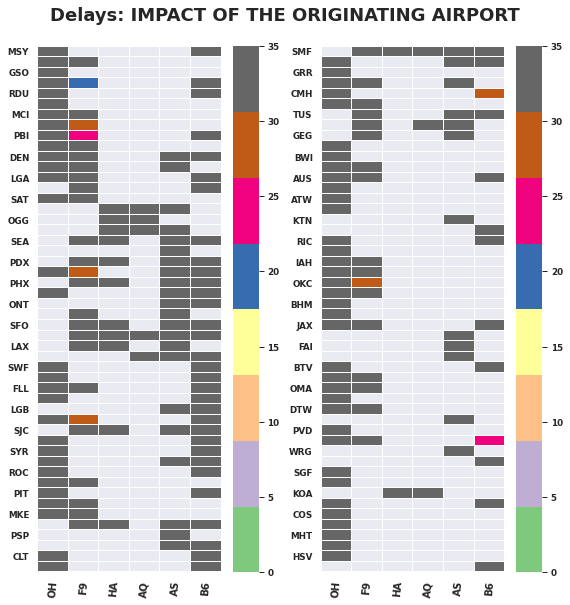

In [60]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:]

mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:]

fig.text(0.5, 1.02, "Delays: IMPACT OF THE ORIGINATING AIRPORT", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

# MODELLING

**My Kernel Keeps Crashing So for modelling I will only use data for Unique carriers "WN" and "NW"**

In [61]:
Carrier = ["WN", "NW"]
df = df[df['UniqueCarrier'].isin(Carrier)]

In [63]:
df['Day'] = df['DayofMonth']
df['DATE'] = pd.to_datetime(df[['Year','Month', 'Day']])
#df.head()

# Treating Missing Values

In [64]:
#The Missing Values for Weather Delays, Security Delays, Arrival Delayy, Departure delays, CarrierDealys and NASDelay are replaced by 0
df['WeatherDelay'] = df['WeatherDelay'].fillna(0)
df['SecurityDelay'] = df['SecurityDelay'].fillna(0)
df['ArrDelay'] = df['ArrDelay'].fillna(0)
df['DepDelay'] = df['DepDelay'].fillna(0)
df['CarrierDelay'] = df['CarrierDelay'].fillna(0)
df['NASDelay'] = df['NASDelay'].fillna(0)
df['LateAircraftDelay'] = df['LateAircraftDelay'].fillna(0)

#The Missing Values for Arrival and Departure time, Taxi in and Taxi out are replaced by the respective mean values of these features.
DepTime_mean = df['DepTime'].mean()
df['DepTime'] = df['DepTime'].fillna(DepTime_mean)
ArrTime_mean = df['ArrTime'].mean()
df['ArrTime'] = df['ArrTime'].fillna(ArrTime_mean)

TaxiIn_mean = df['TaxiIn'].mean()
df['TaxiIn'] = df['TaxiIn'].fillna(TaxiIn_mean)
TaxiOut_mean = df['TaxiOut'].mean()
df['TaxiOut'] = df['TaxiOut'].fillna(TaxiOut_mean)
TaxiIn_mean = df['AirTime'].mean()

In [65]:
#At this point, I simply remove the remaining missing values
df = df.dropna()

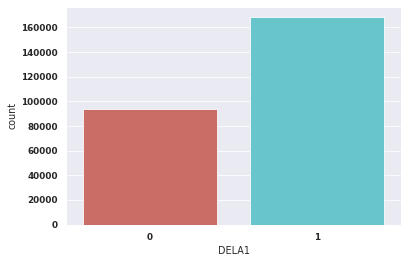

In [66]:
sns.countplot(x = "DELA1", data = df, palette = "hls")
plt.show()

In [67]:
# From The above, we can see that the departure delay is oversampled. 

count_no_sub = len(df[df['DELA1']== 0])
count_sub = len(df[df['DELA1']== 1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no delay", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of delay", pct_of_sub*100)

#From below, we can see that the dataset is imbalanced. The dataset will be balanced shortly after we create dummy values for our categorical variables.


percentage of no delay 35.89166507724585
percentage of delay 64.10833492275415


In [68]:
#We get Dummies for all categorical Variables and drop further variables that might not be needed for our analysis.

delete_columns = ['Year', 'Month', "DATE", 'DayofMonth', 'DayOfWeek',  'CRSDepTime', 'CRSArrTime', "ActualElapsedTime", "Cancelled",           
                      'Diverted', 'CancellationCode', "Unnamed: 0", "Day", "FlightNum", "TailNum", "DepTime", "ArrTime", "CRSElapsedTime",
                 ]

df_new = df.drop(delete_columns,axis=1)


In [69]:
cat_var =["UniqueCarrier", "Origin", "Dest"]
for var in cat_var:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_new[var], prefix=var)
    data1=df_new.join(cat_list)
    data=data1


In [70]:
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_var]

In [71]:
data_final=data[to_keep]
#data_final.columns.values

# At this point, we sample our dataset

In [75]:
from imblearn.over_sampling import SMOTE

In [76]:
X = data_final.loc[:, data_final.columns != 'DELA1']
y = data_final.loc[:, data_final.columns == 'DELA1']

In [77]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [78]:
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['DELA1'])


In [79]:
os_data_y.value_counts()

DELA1
1        117729
0        117729
dtype: int64

In [80]:
columns = ['AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 
    'SecurityDelay','LateAircraftDelay', 'Dest_ABQ', 'Dest_ALB', 'Dest_AMA', 'Dest_ANC', 'Dest_ATL', 'Dest_AUS', 'Dest_AZO', 
    'Dest_BDL','Dest_BHM', 'Dest_BIL', 'Dest_BIS', 'Dest_BNA', 'Dest_BOI', 'Dest_BOS', 'Dest_BTR', 'Dest_BUF', 'Dest_BUR',
    'Dest_BWI','Dest_BZN', 'Dest_CID', 'Dest_CLE', 'Dest_CLT', 'Dest_CMH','Dest_COS', 'Dest_CRP', 'Dest_DAL', 'Dest_DCA', 
    'Dest_DEN','Dest_DFW', 'Dest_DLH', 'Dest_DSM', 'Dest_DTW', 'Dest_EGE','Dest_ELP', 'Dest_EWR', 'Dest_FAI', 'Dest_FAR',
    'Dest_FCA','Dest_FLL', 'Dest_FNT', 'Dest_FSD', 'Dest_GEG', 'Dest_GFK','Dest_GPT', 'Dest_GRB', 'Dest_GRR', 'Dest_HDN',
    'Dest_HNL','Dest_HOU', 'Dest_HRL', 'Dest_IAD', 'Dest_IAH', 'Dest_IND','Dest_ISP', 'Dest_JAC', 'Dest_JAN', 'Dest_JAX',
    'Dest_JFK','Dest_KOA', 'Dest_LAN', 'Dest_LAS', 'Dest_LAX', 'Dest_LBB','Dest_LGA', 'Dest_LIT', 'Dest_LSE', 'Dest_MAF',
    'Dest_MBS','Dest_MCI', 'Dest_MCO', 'Dest_MDT', 'Dest_MDW', 'Dest_MEM','Dest_MHT', 'Dest_MIA', 'Dest_MKE', 'Dest_MOT',
    'Dest_MSN','Dest_MSO', 'Dest_MSP', 'Dest_MSY', 'Dest_MYR', 'Dest_OAK','Dest_OGG', 'Dest_OKC', 'Dest_OMA', 'Dest_ONT',
    'Dest_ORD','Dest_ORF', 'Dest_PBI', 'Dest_PDX', 'Dest_PHL', 'Dest_PHX','Dest_PIT', 'Dest_PSP', 'Dest_PVD', 'Dest_RAP',
    'Dest_RDU','Dest_RNO', 'Dest_ROC', 'Dest_RST', 'Dest_RSW', 'Dest_SAN','Dest_SAT', 'Dest_SDF', 'Dest_SEA', 'Dest_SFO', 
    'Dest_SJC','Dest_SJU', 'Dest_SLC', 'Dest_SMF', 'Dest_SNA', 'Dest_SRQ','Dest_STL', 'Dest_STT', 'Dest_SYR', 'Dest_TPA',
    'Dest_TUL','Dest_TUS', 'Dest_TVC', 'Dest_VPS', 'Dest_XNA']



In [81]:
X=os_data_X[columns]
y=os_data_y['DELA1']

In [82]:
import statsmodels.api as sm

In [83]:

logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')
#print(result.summary2())

/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.173246
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 39


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [84]:
cols = ['AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'Dest_BUR', 'Dest_BWI', 'Dest_DAL',  'Dest_DTW',
       'Dest_HOU',  'Dest_LAS', 'Dest_LAX',  'Dest_MSP', 'Dest_PHL', 'Dest_PHX',
        'Dest_SAN', 'Dest_SAT',  'Dest_SEA', 'Dest_SJC']

In [85]:
X=os_data_X[cols]
y=os_data_y['DELA1']

In [86]:
logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')
print(result.summary2())

/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.175320
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 39


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.747      
Dependent Variable:  DELA1            AIC:              82610.9491 
Date:                2020-12-02 11:18 BIC:              82870.1813 
No. Observations:    235458           Log-Likelihood:   -41280.    
Df Model:            24               LL-Null:          -1.6321e+05
Df Residuals:        235433           LLR p-value:      0.0000     
Converged:           0.0000           Scale:            1.0000     
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
AirTime           -0.1430   0.0011 -135.1598 0.0000 -0.1451 -0.1409
ArrDelay           0.0904   0.0019   47.4872 0.0000  0.0866  0.0941
DepDelay           0.3517   0.0024  146.0333 0.0000  0.3470  0.3565
Distance           0.0163   0.0001  127.8842 0.0000  0.0161  0.0166
TaxiIn 

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [88]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [89]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


In [90]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[32761  2488]
 [ 2399 32990]]


In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     35249
           1       0.93      0.93      0.93     35389

    accuracy                           0.93     70638
   macro avg       0.93      0.93      0.93     70638
weighted avg       0.93      0.93      0.93     70638



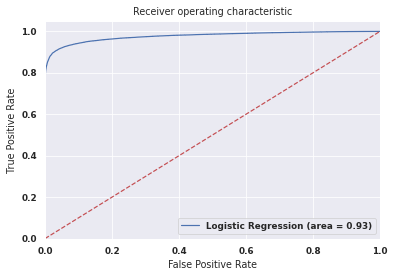

In [92]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()